In [4]:
# 从零开始实现整个方法：包括数据流水线、模型、损失函数、小批量随机梯度下降优化器
# %pip install d2l：IPython 魔术命令；当前Jupyter内核的Python环境；更推荐，尤其是在管理多个环境时；更安全，知道当前环境
# !pip install d2l：Shell 命令前缀；系统路径中找到的 pip 所属环境；不太推荐，可能导致环境混乱；可能有风险，环境不确定
# %pip install d2l      # 未安装 d2l 库时清取消注释
# %matplotlib inline
import random
import torch
from d2l import torch as d2l

features: tensor([0.9430, 1.1122]) 
label: tensor([2.2963])


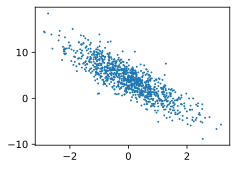

In [5]:
# 根据带有噪声的线性模型构造一个人造数据集，使用线性模型参数：权重w，偏置b，噪声ϵ生成数据集features及其标签lables
def synthetic_data(w,b,num_examples):
    """
    生成y=Xw+b+ϵ
    """
    # torch.normal()是PyTorch中一个非常常用的方法，用于从正态分布（高斯分布）中生成随机数张量
    # 初始化神经网络的权重时，我们经常希望它们从一个小的随机值开始，这些值通常服从正态分布
    X=torch.normal(0,1,(num_examples,len(w)))   # 生成一个均值为0，标准差为1的num_examples x len(w)张量
    # torch.matmul()是最通用和灵活的矩阵乘法操作，因为它能根据输入维度自动适应不同的乘法类型，包括批量乘法和广播
    y=torch.matmul(X,w)+b
    # torch.normal()生成的噪声是均值为0，标准差为0.01的张量，形状与y相同
    # shape是张量的一个属性，它返回一个元组（tuple），表示张量在每个维度上的大小（元素的数量）。是一个只读属性，不能直接修改tensor.shape来改变张量的形状
    y+=torch.normal(0,0.01,y.shape) # 添加噪声，生成标签
    # 返回特征X和标签y，y被reshape成列向量（-1表示未指定行数，可以是任意行，1表示只有一列）
    return X,y.reshape((-1,1))
# true_w既不是严格意义上的行向量，也不是严格意义上的列向量，因为行向量和列向量通常指二维张量
# torch.tensor([2,-3.4])生成的一维张量shape是(2,)。这个形状元组中只有一个数字2，表示它只有一个维度，并且该维度上有2个元素
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

# features每一行都包含一个二维数据样本，labels每一行都包含对应的标签（一个标量）
print('features:',features[0],'\nlabel:',labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

In [6]:
# 定义一个data_iter函数，该函数接收批量大小batch_size、特征矩阵features、标签向量labels，生成大小为batch_size的小批量数据迭代器
def data_iter(batch_size, features, labels):
    num_examples = len(features)  # 获取特征矩阵的行数，即样本数量（矩阵列数是特征数量）
    indices = list(range(num_examples))
    # 样本是随机读取的，没有特定的顺序，这有助于打破数据的相关性，避免模型过拟合
    random.shuffle(indices)  # 打乱索引的list，但是features和labels的顺序保持不变
    for i in range(0, num_examples, batch_size): #循环将features和labels分成小批量乱序数据
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
batch_size = 10  # 设置批量大小
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break  # 只打印第一个批次的数据

tensor([[-1.0144,  0.5690],
        [-1.3289,  0.3844],
        [-0.7760,  1.1397],
        [ 1.2414, -2.3489],
        [ 0.2792,  1.2799],
        [-1.3473, -1.9492],
        [ 1.1660, -0.9131],
        [ 2.0579,  0.7877],
        [-0.4014, -2.1546],
        [-0.4901,  0.5414]]) 
 tensor([[ 0.2276],
        [ 0.2537],
        [-1.2416],
        [14.6866],
        [ 0.3986],
        [ 8.1284],
        [ 9.6391],
        [ 5.6385],
        [10.7115],
        [ 1.3873]])


In [15]:
# 定义初始化模型参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)  # 权重，2行1列
b=torch.zeros(1,requires_grad=True)  # 偏置，1行1列
# requires_grad=True表示需要计算梯度，便于后续的反向传播

# 定义模型
def linreg(X, w, b):
    """
    线性回归模型
    """
    return torch.matmul(X, w) + b  # 矩阵乘法加偏置

# 定义损失函数
def squared_loss(y_hat, y):
    """
    平方损失函数（均方误差）
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  # 平方损失除以2，便于后续求导时简化计算

# 定义优化算法
def sgd(params, lr, batch_size):
    """
    小批量随机梯度下降优化器
    """
    with torch.no_grad():  # 在不需要梯度计算的上下文中进行参数更新
        for param in params:
            param -= lr * param.grad / batch_size  # 更新参数（可能是权重w或偏置b）
            param.grad.zero_()  # 清除梯度，准备下一次迭代

# 训练过程
lr=10
num_epochs=10
net=linreg
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)    # X，y的小批量损失
        l.sum().backward()  # 反向传播，计算梯度
        sgd([w,b],lr,batch_size)  # 使用参数的梯度更新
    with torch.no_grad():   # 只需更新参数而无须计算梯度，节约内存
        train_l=loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean())}')

epoch 1,loss nan
epoch 2,loss nan
epoch 3,loss nan
epoch 4,loss nan
epoch 5,loss nan
epoch 6,loss nan
epoch 7,loss nan
epoch 8,loss nan
epoch 9,loss nan
epoch 10,loss nan


In [11]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f"w的估计误差：{true_w-w.reshape(true_w.shape)}")
print(f"b的估计误差：{true_b-b}")

w的估计误差：tensor([ 0.0006, -0.0003], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0002], grad_fn=<RsubBackward1>)
